In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from dataloader import *
from transformer import *

# Model definition

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.kaiming_uniform(m.weight.data)

In [4]:
def plot_training(history, marker=None):
    # put everything on cpu
    for key, value in history.items():
        history[key] = [element.cpu() if isinstance(element, torch.Tensor) else element for element in value]

    plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.5,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training loss')

    # vertical line for marking best epoch
    if marker is not None:
        y_min = min(history['train_loss'] + history['val_loss'])
        y_max = max(history['train_loss'] + history['val_loss'])
        plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training metric')

    # vertical line for marking best epoch
    if marker is not None:
        y_min = min(history['train_acc'] + history['val_acc'])
        y_max = max(history['train_acc'] + history['val_acc'])
        plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

    plt.show()

In [5]:
def validation(model, iterator, optimizer, criterion, device):
    # set model into evaluation mode
    model.eval()

    # validation
    # loss, metrics for current epoch
    val_epoch_loss = 0
    val_epoch_accuracy = 0

    with torch.no_grad(): # stop graph
        # batches
        for i, batch in enumerate(iterator):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            output = model(src)
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)

            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy

            val_epoch_loss += loss.item()
            val_epoch_accuracy += accuracy

    # return mean loss w.r.t. batches
    return val_epoch_loss / len(iterator), val_epoch_accuracy / len(iterator)

def train(model, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, 'min')

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': []}

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)

        # save data
        with torch.no_grad():
          for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc]):
            history[key].append(value)

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}")

    # print training curve
    plot_training(history)

    return history

def train_save_best(model, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': [],
               'learning_rate': []}
    best_model = None
    best_model_score = 1e9
    best_model_epoch = 0

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)
        
        scheduler.step(val_loss)

        # save data
        with torch.no_grad():
            current_lr = optimizer.param_groups[0]['lr']

            for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc, current_lr]):
                history[key].append(value)

            # save best model (w.r.t validation loss)
            if val_loss < best_model_score:
                best_model = model.state_dict()
                best_model_score = val_loss
                best_model_epoch = e

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}, \
              Learning Rate : {optimizer.param_groups[0]['lr'] :.4f}")

    # print training curve
    plot_training(history, marker=best_model_epoch)

    return history, best_model, best_model_score

# Import data

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
# init
tokenizer = Tokenizer()
loader = DataLoader(tokenize = tokenizer.tokenize)

# import data (combine train/test as we split afterwards anyways)
# data = pd.concat([pd.read_csv("./Data/IMDB Dataset.csv", encoding='ISO-8859-1'),
#                   pd.read_csv("./Data/IMDB Dataset.csv", encoding='ISO-8859-1')])
data = pd.read_csv("./Data/IMDB Dataset.csv", encoding='ISO-8859-1')
# convert string label to binary (int) label (spam:1, non-spam:0)
data["sentiment"] = data['sentiment'].apply(lambda x : int(x == "positive"))

# train, test, val split
train, valid, test = loader.make_dataset(data)
vocab = loader.get_vocab(train.iloc[:, 0])
train_iter, valid_iter, test_iter = loader.make_iter(train, valid, test,
                                                     batch_size=512,
                                                     device=device)

# NLP stuff
pad_idx = vocab['__PAD__']
voc_size = len(vocab)
print("Vocabulary Size : ", voc_size)

dataset initializing start
Length of data after first step of preprocessing:  35832
Tokenizing the data...


c:\Users\atace\OneDrive\Desktop\ETH\9.Semester\Deep Learning\project\Exploring-Model-Fusion-with-Optimal-Transport-on-Transformers\dataloader.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["len"] = data.iloc[:, 0].apply(lambda x : len(self.tokenize(x)))


Length of the data :  29544
0
review       [[CLS], one, of, the, many, silent, comedies, ...
sentiment                                                    0
len                                                        186
Name: 46539, dtype: object


100%|██████████| 2955/2955 [00:00<00:00, 7109.58it/s] 


dataset initializing done
Vocabulary Size :  23050


In [12]:
# Creating the embedding matrix
embedding = torch.nn.Embedding(voc_size, 16)

# Training

Idea: We train model A and model B for long enough, s.t. they start overfitting. We use their best models w.r.t. validation set (i.e. not the final model after all training epochs) and fuse them together. The fused model is then trained for long enough as well, saving the best model w.r.t to the same validation set. The fused model is then compared with its parent models on the separate test set.


note that dataset is imbalanced -> accuracy is not a good metric

  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\atace\AppData\Local\Temp/ipykernel_2592/3037923790.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 47/47 [04:45<00:00,  6.07s/it]
C:\Users\atace\AppData\Local\Temp/ipykernel_2592/3037923790.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.7877               Validation Loss: 0.7044               Train acc: 0.5093,               Val acc: 0.5194,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:51<00:00,  3.65s/it]


Epoch: 2  Train Loss: 0.7197               Validation Loss: 0.7555               Train acc: 0.5358,               Val acc: 0.5051,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:19<00:00,  4.25s/it]


Epoch: 3  Train Loss: 0.6872               Validation Loss: 0.6983               Train acc: 0.5827,               Val acc: 0.5545,               Learning Rate : 0.0010


100%|██████████| 47/47 [05:03<00:00,  6.46s/it]


Epoch: 4  Train Loss: 0.6341               Validation Loss: 0.6992               Train acc: 0.6367,               Val acc: 0.5846,               Learning Rate : 0.0010


100%|██████████| 47/47 [04:59<00:00,  6.37s/it]


Epoch: 5  Train Loss: 0.6086               Validation Loss: 0.6205               Train acc: 0.6668,               Val acc: 0.6590,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:08<00:00,  4.02s/it]


Epoch: 6  Train Loss: 0.5322               Validation Loss: 0.5678               Train acc: 0.7341,               Val acc: 0.7027,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:14<00:00,  4.14s/it]


Epoch: 7  Train Loss: 0.5290               Validation Loss: 0.6637               Train acc: 0.7390,               Val acc: 0.6739,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:35<00:00,  4.58s/it]


Epoch: 8  Train Loss: 0.5025               Validation Loss: 0.5441               Train acc: 0.7560,               Val acc: 0.7340,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:33<00:00,  4.53s/it]


Epoch: 9  Train Loss: 0.4777               Validation Loss: 0.5882               Train acc: 0.7697,               Val acc: 0.7144,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:59<00:00,  5.10s/it]


Epoch: 10  Train Loss: 0.4551               Validation Loss: 0.5188               Train acc: 0.7835,               Val acc: 0.7450,               Learning Rate : 0.0010


100%|██████████| 47/47 [04:35<00:00,  5.86s/it]


Epoch: 11  Train Loss: 0.4003               Validation Loss: 0.4946               Train acc: 0.8152,               Val acc: 0.7602,               Learning Rate : 0.0010


100%|██████████| 47/47 [04:08<00:00,  5.29s/it]


Epoch: 12  Train Loss: 0.3793               Validation Loss: 0.4962               Train acc: 0.8276,               Val acc: 0.7733,               Learning Rate : 0.0010


100%|██████████| 47/47 [04:01<00:00,  5.14s/it]


Epoch: 13  Train Loss: 0.3403               Validation Loss: 0.4785               Train acc: 0.8503,               Val acc: 0.7887,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:58<00:00,  5.07s/it]


Epoch: 14  Train Loss: 0.3095               Validation Loss: 0.5039               Train acc: 0.8667,               Val acc: 0.7736,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:46<00:00,  4.82s/it]


Epoch: 15  Train Loss: 0.2977               Validation Loss: 0.4463               Train acc: 0.8701,               Val acc: 0.8159,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:42<00:00,  4.74s/it]


Epoch: 16  Train Loss: 0.2590               Validation Loss: 0.4491               Train acc: 0.8938,               Val acc: 0.8196,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:59<00:00,  3.82s/it]


Epoch: 17  Train Loss: 0.2441               Validation Loss: 0.4441               Train acc: 0.8991,               Val acc: 0.8245,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:17<00:00,  4.20s/it]


Epoch: 18  Train Loss: 0.2344               Validation Loss: 0.5070               Train acc: 0.9045,               Val acc: 0.8100,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:39<00:00,  4.67s/it]


Epoch: 19  Train Loss: 0.2204               Validation Loss: 0.5035               Train acc: 0.9093,               Val acc: 0.8126,               Learning Rate : 0.0010


100%|██████████| 47/47 [04:11<00:00,  5.36s/it]


Epoch: 20  Train Loss: 0.2044               Validation Loss: 0.4469               Train acc: 0.9155,               Val acc: 0.8265,               Learning Rate : 0.0010


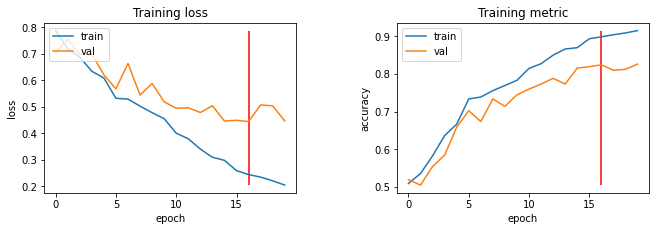

Wall time: 1h 21min 43s


In [13]:
%%time
# train model A
modelA = TransformerClassifier(embedding=embedding,
                              src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 16,
                              ffn_hidden = 32,
                              n_head = 4,
                              n_layers = 1,
                              drop_prob = 0.5,
                              device = device)
modelA = modelA.to(device) # put on CPU/GPU

optA = torch.optim.Adam(modelA.parameters(), lr=0.001)
loss_fnA = nn.CrossEntropyLoss()


epochs = 20

historyA, best_modelA, best_model_scoreA = train_save_best(model=modelA,
                                                            iterator=train_iter,
                                                            optimizer=optA,
                                                            criterion=loss_fnA,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelA, './Models/modelA_IMDB_256_multihead')

# save history
with open('./Models/history_modelA_IMDB_256_multihead.txt', 'w') as dat:
    dat.write(str(historyA))

In [25]:
embeddingB = nn.Embedding.from_pretrained(best_modelA['encoder.emb.tok_emb.embedding.weight'])

In [27]:
embeddingB.weight

Parameter containing:
tensor([[-3.8502e-01,  1.1262e+00,  1.3417e-03,  ..., -7.5502e-01,
         -9.0018e-01,  8.8784e-01],
        [ 1.1537e-01, -1.2032e-01,  1.4432e+00,  ..., -7.6122e-01,
         -9.3169e-01, -8.5554e-01],
        [ 1.7445e-01, -1.4995e+00,  2.9681e-01,  ..., -6.8483e-02,
          9.6062e-01,  9.2291e-01],
        ...,
        [ 2.4505e-01,  7.5237e-01, -2.2785e+00,  ...,  1.0050e+00,
          7.7714e-01,  2.7798e-01],
        [-5.8271e-01,  8.3331e-01,  1.8947e+00,  ...,  2.2208e-02,
          9.4553e-01,  6.0973e-01],
        [-7.8761e-01, -8.8649e-01, -1.1720e+00,  ...,  1.4213e+00,
          1.1255e+00,  1.8909e-01]])

  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\atace\AppData\Local\Temp/ipykernel_2592/3037923790.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 47/47 [04:42<00:00,  6.02s/it]
C:\Users\atace\AppData\Local\Temp/ipykernel_2592/3037923790.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.7568               Validation Loss: 0.7274               Train acc: 0.5492,               Val acc: 0.5664,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:30<00:00,  3.20s/it]


Epoch: 2  Train Loss: 0.5459               Validation Loss: 0.4701               Train acc: 0.7108,               Val acc: 0.7799,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:39<00:00,  3.40s/it]


Epoch: 3  Train Loss: 0.3353               Validation Loss: 0.4931               Train acc: 0.8516,               Val acc: 0.7923,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:13<00:00,  4.12s/it]


Epoch: 4  Train Loss: 0.3072               Validation Loss: 0.3948               Train acc: 0.8650,               Val acc: 0.8369,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:42<00:00,  3.47s/it]


Epoch: 5  Train Loss: 0.2599               Validation Loss: 0.4453               Train acc: 0.8907,               Val acc: 0.8097,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:15<00:00,  4.16s/it]


Epoch: 6  Train Loss: 0.2543               Validation Loss: 0.4253               Train acc: 0.8915,               Val acc: 0.8269,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:36<00:00,  3.34s/it]


Epoch: 7  Train Loss: 0.2444               Validation Loss: 0.4840               Train acc: 0.8965,               Val acc: 0.8158,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:54<00:00,  3.72s/it]


Epoch: 8  Train Loss: 0.2746               Validation Loss: 0.5000               Train acc: 0.8832,               Val acc: 0.7981,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:24<00:00,  4.36s/it]


Epoch: 9  Train Loss: 0.2566               Validation Loss: 0.4342               Train acc: 0.8915,               Val acc: 0.8318,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:33<00:00,  4.54s/it]


Epoch: 10  Train Loss: 0.2193               Validation Loss: 0.4555               Train acc: 0.9094,               Val acc: 0.8272,               Learning Rate : 0.0001


100%|██████████| 47/47 [02:38<00:00,  3.37s/it]


Epoch: 11  Train Loss: 0.1975               Validation Loss: 0.4393               Train acc: 0.9208,               Val acc: 0.8283,               Learning Rate : 0.0001


100%|██████████| 47/47 [02:39<00:00,  3.40s/it]


Epoch: 12  Train Loss: 0.1964               Validation Loss: 0.4406               Train acc: 0.9220,               Val acc: 0.8331,               Learning Rate : 0.0001


100%|██████████| 47/47 [02:35<00:00,  3.30s/it]


Epoch: 13  Train Loss: 0.1959               Validation Loss: 0.4353               Train acc: 0.9215,               Val acc: 0.8343,               Learning Rate : 0.0001


100%|██████████| 47/47 [02:32<00:00,  3.23s/it]


Epoch: 14  Train Loss: 0.1941               Validation Loss: 0.4391               Train acc: 0.9219,               Val acc: 0.8313,               Learning Rate : 0.0001


100%|██████████| 47/47 [02:43<00:00,  3.47s/it]


Epoch: 15  Train Loss: 0.1924               Validation Loss: 0.4404               Train acc: 0.9232,               Val acc: 0.8328,               Learning Rate : 0.0001


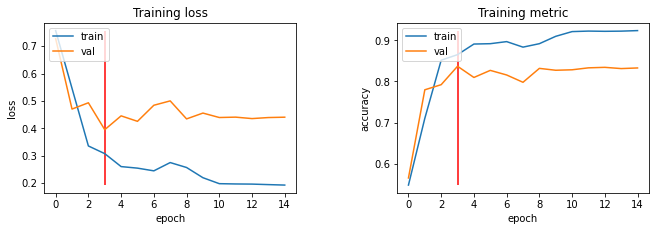

Wall time: 47min 53s


In [28]:
%%time
# train model B
modelB = TransformerClassifier(embedding=embeddingB,
                              src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 16,
                              ffn_hidden = 32,
                              n_head = 4,
                              n_layers = 1,
                              drop_prob = 0.5,
                              device = device)
modelB = modelB.to(device) # put on CPU/GPU

optB = torch.optim.Adam(modelB.parameters(), lr=0.001)
loss_fnB = nn.CrossEntropyLoss()


epochs = 15

historyB, best_modelB, best_model_scoreB = train_save_best(model=modelB,
                                                            iterator=train_iter,
                                                            optimizer=optB,
                                                            criterion=loss_fnB,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelB, './Models/modelB_IMDB_256_multihead')

# save history
with open('./Models/history_modelB_IMDB_256_multihead.txt', 'w') as dat:
    dat.write(str(historyB))

In [30]:
torch.save(embeddingB, "Models\embedding_16_trained_multihead.pt")

# Model fusion

### Definitions

In [ ]:
def weight_averaging(*weights):
  with torch.no_grad():
    sum = torch.zeros(weights[0].shape, device=device)
    for weight in weights:
      sum += weight
  return sum / len(weights)

In [ ]:
def linear_averaging(*linears):
  """Averages several linear layers (weights + biases)"""
  with torch.no_grad():
    weights = [linear.weight for linear in linears]
    biases = [linear.bias for linear in linears]

    linear_averaged = torch.nn.Linear(linears[0].in_features, linears[0].out_features, bias=True).to(device)
    linear_averaged.weight, linear_averaged.bias = torch.nn.Parameter(weight_averaging(*weights)), torch.nn.Parameter(weight_averaging(*biases))

  return linear_averaged

In [ ]:
def vanilla_fusion(modelA, modelB):
  # init
  model_fusion = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

  with torch.no_grad():
    # 1) encoder
    # TODO: smarter method for embedding
    # a) embedding
    weights_A = modelA.encoder.emb.tok_emb.weight
    weights_B = modelB.encoder.emb.tok_emb.weight

    weights_fusion = weight_averaging(weights_A, weights_B) # weights seem to be exactly the same?
    model_fusion.encoder.emb.tok_emb.weight = torch.nn.Parameter(weights_fusion)

    # b) encoder layers
    for i, _ in enumerate(modelA.encoder.layers):
      # i) self-attention (fuse Q, K, V separately) # TODO: check validity of this approach
      # query
      query_A = modelA.encoder.layers[i].attention.w_q
      query_B = modelB.encoder.layers[i].attention.w_q

      query_fusion = linear_averaging(query_A, query_B)
      model_fusion.encoder.layers[i].attention.w_q = query_fusion

      # key
      key_A = modelA.encoder.layers[i].attention.w_k
      key_B = modelB.encoder.layers[i].attention.w_k

      key_fusion = linear_averaging(key_A, key_B)
      model_fusion.encoder.layers[i].attention.w_k = key_fusion

      # value
      value_A = modelA.encoder.layers[i].attention.w_v
      value_B = modelB.encoder.layers[i].attention.w_v

      value_fusion = linear_averaging(value_A, value_B)
      model_fusion.encoder.layers[i].attention.w_v = value_fusion

      # output
      output_A = modelA.encoder.layers[i].attention.w_concat
      output_B = modelB.encoder.layers[i].attention.w_concat

      output_fusion = linear_averaging(output_A, output_B)
      model_fusion.encoder.layers[i].attention.w_concat = output_fusion

      # ii) layer norm 1
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

      # iii) feed-forward network
      # layer 1
      linear_A = modelA.encoder.layers[i].ffn.linear1
      linear_B = modelB.encoder.layers[i].ffn.linear1

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear1 = linear_fusion

      # layer 2
      linear_A = modelA.encoder.layers[i].ffn.linear2
      linear_B = modelB.encoder.layers[i].ffn.linear2

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear2 = linear_fusion

      # iv) layer norm 2
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

    # 2) MLP head
    linear_A = modelA.linear
    linear_B = modelB.linear

    linear_fusion = linear_averaging(linear_A, linear_B)
    model_fusion.linear = linear_fusion

  return model_fusion

In [ ]:
def test_fusion(modelA, modelB, model_fusion):
  # test fusion
  test_loss_A, test_acc_A = validation(modelA, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_B, test_acc_B = validation(modelB, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_fusion, test_acc_fusion = validation(model_fusion, test_iter, None, nn.CrossEntropyLoss(), device)

  # visualize
  fig, ax = plt.subplots()

  metrics_A = [test_loss_A, test_acc_A]
  metrics_B = [test_loss_B, test_acc_B]
  metrics_fusion = [test_loss_fusion, test_acc_fusion]
  metrics = ['loss', 'accuracy']
  x = np.arange(len(metrics)) # positions of bars (1 per metric)
  width = 0.25  # the width of the bars

  rects1 = ax.bar(x - width, metrics_A, width, label='model A')
  rects2 = ax.bar(x, metrics_B, width, label='model B')
  rects3 = ax.bar(x + width, metrics_fusion, width, label='model fusion')

  ax.set_ylabel('Score')
  ax.set_title('Test metrics by models')
  ax.set_xticks(x)
  ax.set_xticklabels(metrics)
  ax.legend()

  plt.show()

### (Optional) load models

In [ ]:
# load parent models
# TODO: change enc_voc_size back
modelA = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)
modelB = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

modelA.load_state_dict(torch.load('./Models/modelA'))
modelB.load_state_dict(torch.load('./Models/modelB'))

### Fusion

Vanilla fusion

In [ ]:
model_fusion = vanilla_fusion(modelA, modelB)

Optimal transport

In [ ]:
model_fusion = TransformerClassifier(src_pad_idx = pad_idx,
                               enc_voc_size = voc_size,
                               max_len = 256,
                               d_model = 512,
                               ffn_hidden = 2048,
                               n_head = 1,
                               n_layers = 1,
                               drop_prob = 0.1,
                               device = device)

model_fusion.load_state_dict(torch.load('./Models/model_fusion_OT_pre_retraining'))

### Test fusion

Randomly initialiized model for comparison

In [ ]:
# test with new randomly initialized transformer
test_fusion(modelA, modelB, TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device))

Fusion model

In [ ]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)

### Retraining

In [ ]:
model_name = 'model_fusion_OT_post_retraining'

In [ ]:
%%time
opt_fusion = torch.optim.SGD(model_fusion.parameters(), lr=0.001)
loss_fn_fusion = nn.CrossEntropyLoss()


epochs = 200
history_fusion, best_model_fusion, best_model_score_fusion = train_save_best(model=model_fusion,
                                                                             iterator=train_iter,
                                                                             optimizer=opt_fusion,
                                                                             criterion=loss_fn_fusion,
                                                                             epoch=epochs,
                                                                             clip=1,
                                                                             device=device)

In [ ]:
# save model
torch.save(best_model_fusion, f'./Models/{model_name}')

# save history
with open(f'./Models/history_{model_name}.txt', 'w') as dat:
    dat.write(str(history_fusion))

In [ ]:
# load best model (current model is trained on full epochs)
model_fusion.load_state_dict(best_model_fusion)

### Test fusion (after retraining)

In [ ]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)